In [1]:
from z3 import *
from sklearn.datasets import make_blobs

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import itertools
import time
import random

In [3]:
import pandas as pd

# Misc 

In [4]:
def quantize_X(x, b=8):
    
    xq = x.copy()
    xd = x.copy()
    for i in range(x.shape[1]):
        s=(2**b-1)/np.max(abs(x), axis=0)[i]
        xq[:,i] = np.round(s*x[:,i])
        xd[:,i] = xq[:,i]/s

    return xq, xd

# z-threeml

In [5]:
def get_value(x):
  if is_int_value(x):
    return x.as_long()
  if is_rational_value(x):
    return x.numerator_as_long() / x.denominator_as_long()
  if is_algebraic_value(x):
    return x.approx()
  if x == None:
     return 0
  raise ValueError(f"I don't know what {x} is")

def argmax(logits, ix, max_val):
    # Based on http://www.hakank.org/z3/argmax.py
    terms = []
    terms.append(Or([max_val == logits[i] for i in range(len(logits))]))
    for i in range(len(logits)):
        terms.append((ix == i) == (logits[i] == max_val))
    return terms

def maximum(logits, max_val):
    # Based on http://www.hakank.org/z3/max.py
    terms = []
    terms.append(Or([max_val == logits[i] for i in range(len(logits))]))
    for i in range(len(logits)):
        terms.append(max_val >= logits[i])
    return terms

In [6]:
class z3Linear:
  def __init__(self, n_features, dtype=Real):
    self.w = np.array([dtype(f"w_{i}") for i in range(n_features)])
    self.b = np.array([dtype("b")])
    ## jje: init w, b as Real variables

  def forward(self, x):
    return x @ self.w + self.b
    # jje: what is that @ decorator in this function?

  def pred(self, x):
    logits = self.forward(x)
    return logits > 0

  def realize(self, model):
    self.w = np.array([get_value(model[w]) for w in self.w.ravel()]).reshape(*self.w.shape)
    self.b = np.array([get_value(model[b]) for b in self.b.ravel()]).reshape(*self.b.shape)

    return self
    
    # jje: way to get the values back if the model returned SAT

# This is the loss that should be paired with a 2 class classifier
def threshold_loss(logits, y):
  """Losses return lists or lists of constraints."""
  return [np.vectorize(lambda l, y: If(bool(y == 0), l < 0, l > 0))(logits, y)]
  # jje: if the y (class) is 0, then logit=wx+b should be less than 0 (below the line), pos otherwise
  

In [7]:
class z3MultiClassLinear(z3Linear):
    def __init__(self, n_features, n_output, dtype=Real):
        self.w = np.array(
            [[dtype(f"w_{i},{j}") for j in range(n_output)]
             for i in range(n_features)]
        )
        self.b = np.array([dtype(f"b_{i}") for i in range(n_output)])
        # jje: there will be more than 1 line that separate the classes

    def pred(self, x):
        logits = self.forward(x)
        return np.argmax(logits, axis=-1)

    def loss(self, logits, y):
        terms = []
        for i, (l, y_) in enumerate(zip(logits, y)):
            ts = []
            ix = Int(f"argmax_{i}")
            max_val = Real(f"max_{i}")
            ts.extend(maximum(l, max_val)) # jje: one of the values is the max
            ts.extend(argmax(l, ix, max_val)) # jje: clause for the argmax
            ts.append(ix == y_) # jje: that the idx that max is the class
            terms.append(ts)
        return terms

# This loss is paired with anything that has more than 2 classes
def multiclass_loss(logits, y):
    """Losses return lists of lists of constraints."""
    terms = []
    for i, (l, y_) in enumerate(zip(logits, y)):
        ts = []
        ix = Int(f"argmax_{i}")
        max_val = Real(f"max_{i}")
        ts.extend(maximum(l, max_val))
        ts.extend(argmax(l, ix, max_val))
        ts.append(ix == y_)
        terms.append(ts)
    return terms

In [8]:
def relu(x):
    # Based on https://gist.github.com/philzook58/5aab67b65b476bb55e6b9c403ccabed2
    return np.vectorize(lambda y: If(y >= 0, y, RealVal(0)))(x)

class z3MLP(z3MultiClassLinear):
    def __init__(self, n_features, n_hidden, n_output, dtype=Real):
        self.ws = []
        self.bs = []
        if not isinstance(n_hidden, list):
            n_hidden = [n_hidden]
        for i, (in_, out) in enumerate(zip([n_features, *n_hidden], [*n_hidden, n_output])):
            w = np.array([
                [dtype(f"w_{i},{j},{k}") for k in range(out)]
                for j in range(in_)
            ])
            self.ws.append(w)
            b = np.array([dtype(f"b_{i},{j}") for j in range(out)])
            self.bs.append(b)
        self.relu = relu

    def forward(self, x):
        for w, b in zip(self.ws[:-1], self.bs[:-1]):
            x = x @ w + b
            x = self.relu(x)
        return x @ self.ws[-1] + self.bs[-1]

    def realize(self, m):
        self.ws = [
            np.array([get_value(m[w]) for w in ws.ravel()]).reshape(*ws.shape)
            for ws in self.ws
        ]
        self.bs = [
            np.array([get_value(m[b]) for b in bs.ravel()]).reshape(*bs.shape)
            for bs in self.bs
        ]
        self.relu = lambda x: np.maximum(x, 0)
        return self

In [9]:
def train(x, y, model, loss):
    """The 'training loop'."""
    # Create a symbolic representation of the logits created by the model for every datapoint.
    logits = model.forward(x)
    # Create a constraint that the symbolic logits represent the right answer
    return loss(logits, y)

In [10]:
seed = 42

## Actual data for multi-class classification


In [11]:
import torchvision
import torchvision.datasets as datasets
import torch
from sklearn.decomposition import PCA
from collections import Counter


In [12]:
df = pd.read_csv("../creditcard.csv")

In [14]:
df.columns = [i.lower() for i in df.columns]

In [15]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
df['class'].value_counts()

class
0    284315
1       492
Name: count, dtype: int64

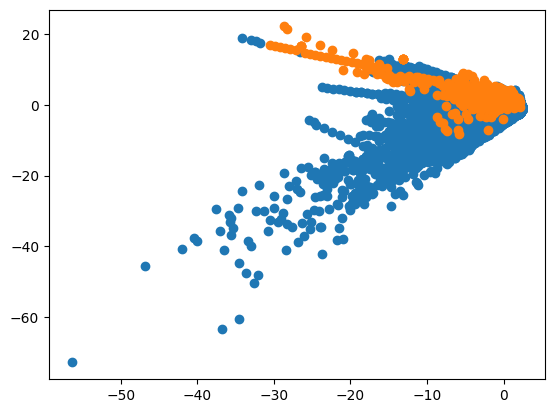

In [18]:
plt.scatter(df[df['class']==0]['v1'], df[df['class']==0]['v2'], label='0')
plt.scatter(df[df['class']==1]['v1'], df[df['class']==1]['v2'], label='1')

In [64]:
train_x = np.array(df[[i for i in df.columns if i != 'class']])
train_y = np.array(df['class'])

test_idx = np.where(train_y==1)[0][:200]
train_idx = np.where(train_y==1)[0][200:]

test_x = train_x[test_idx]
test_y = train_y[test_idx]

train_x = train_x[[i for i in range(train_x.shape[0]) if i not in test_idx]]
train_y = train_y[[i for i in range(train_x.shape[0]) if i not in test_idx]]

In [65]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(284607, 30)
(284407,)
(200, 30)
(200,)


In [85]:
train_idx_balanced = np.where(train_y==0)[0][:292] + np.where(train_y==1)[0]
train_x_b = train_x[train_idx_balanced]
train_y_b = train_y[train_idx_balanced]

In [97]:
ml = z3MultiClassLinear(30, 2)
terms = train(train_x_b, train_y_b, ml, multiclass_loss)

In [98]:
s=Solver()
status = s.check()
if status == sat:
    ml = ml.realize(s.model())
    y_pred = ml.pred(test_x)

In [99]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [13]:
def train_loop(train_x, train_y, test_x, test_y, cls, num_features=784, max_sample=10, use_quantize = False, use_optimize=False):
    construct_time = []
    solve_time = []
    test_acc = []
    test_time = []
    sat_ls = []
    sample_num =[]

    for num_per_class in range(1,max_sample,10):
        
        train_samples, train_labels = construct_train_set(train_x, train_y, num_per_class, cls)
        print(np.unique(train_labels))
        print(train_samples.shape)
        print(train_labels.shape)
        sample_num.append(train_samples.shape[0])

        if use_quantize:
            train_samples, _ = quantize_X(train_samples)
            test_x, _ = quantize_X(test_x) # because the model expects quantized value?
        
        # construct
        ml = z3MultiClassLinear(num_features, len(cls))
        tic = time.time()
        terms = train(train_samples, train_labels, ml, multiclass_loss)
        toc = time.time()
        construct_time.append(toc-tic)
        print(f"Train size {train_samples.shape[0]} constructed in {toc-tic}")

        # solve    
        if use_optimize:
            s = Optimize()  # A MaxSAT solver, it takes longer
            for i, ts in enumerate(terms):
                for j, t in enumerate(ts):
                    if j == (len(ts) - 1):
                        s.add_soft(t)
                    else:
                        s.add(t)
        else:
            s = Solver()
            s.add(*itertools.chain(*terms))
            
        tic = time.time()
        status = s.check()
        toc = time.time()
        solve_time.append(toc-tic)
        sat_ls.append(status)
        print(f"status: {status}")
        print(f"Train size {train_samples.shape[0]} solved in {toc-tic}")

        if status==sat:
            ml = ml.realize(s.model())

            # pred
            cls_idx = [idx for idx, i in enumerate(test_y) if i in cls]
            tic = time.time()
            y_pred = ml.pred(test_x[cls_idx])
            toc = time.time()
            acc = float(sum(y_pred==test_y[cls_idx])/len(y_pred))
            test_acc.append(acc)
            test_time.append(toc-tic)
            print(f"Train size {train_samples.shape[0]} accuracy {acc}, pred time {toc-tic}")
        else:
            test_acc.append(None)
            test_time.append(None)
    
    df = df = pd.DataFrame([sample_num, construct_time, solve_time, test_time, test_acc, sat_ls],
                           index=['sample_num','construct_time','solve_time','test_time','test_acc','sat_ls']).T
    df = df.set_index('sample_num')

    return df, ml

## Load data

In [14]:
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True)

In [15]:
# pca = PCA(n_components=10)
# train_data = pca.fit_transform(trainset.data.flatten(start_dim=1))
train_x= trainset.data.flatten(start_dim=1)
train_y = trainset.targets

test_x = train_x[50000:,:]
test_y = train_y[50000:,]

train_x = train_x[:50000,:]
train_y = train_y[:50000,]

print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)

torch.Size([10000, 784])
torch.Size([10000])
torch.Size([50000, 784])
torch.Size([50000])


In [16]:
pca = PCA(n_components=5)
train_x_pca = pca.fit_transform(trainset.data.flatten(start_dim=1))

test_x_pca = train_x_pca[50000:,:]
train_x_pca = train_x_pca[:50000,:]

print(test_x_pca.shape)
print(train_x_pca.shape)

(10000, 5)
(50000, 5)


## Only test a few classes

**Observations**

*Two class setting*
* Naive approach (increase the # train size and hope the accuracy improves) is noisy. More data samples don't necessarily mean good performance on the test set.
    * TODO: compare with linear regression method
* Solve time increase is exponential; it exceeds construct time after 50 samples per class
* As # classes increase, have more UNSAT instances. For a quick intuition, the overlap between the two classes highlight that. This means that to solve instances with many classes, need to have error permitting solver
* Tried error permitting solver. Much slower.


*with PCA*
* PCA run with MNIST has much better accuracy for 0 vs. 1 class! Near 98% accuracy. Faster solve time as well. << **is this true? verify if true.**
* Better accuracy with more classes!

*Testing the method on other real-world single class  datasets*
* 

In [50]:
construct_time, solve_time, test_acc, test_time, sat_ls, model = train_loop(train_x=train_x, train_y=train_y,
                                                                            test_x=test_x, test_y=test_y, cls=[0,1], max_sample=100)

(2, 784)
(2,)
Train size 2 constructed in 0.31369686126708984
status: sat
Train size 2 solved in 0.20803475379943848


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_70738/1917213297.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return x @ self.w + self.b


Train size 2 accuracy 0.4861313998699188, pred time 0.024985790252685547
(22, 784)
(22,)
Train size 22 constructed in 3.503148078918457
status: sat
Train size 22 solved in 0.5946860313415527
Train size 22 accuracy 0.6681265234947205, pred time 0.02602386474609375
(42, 784)
(42,)
Train size 42 constructed in 5.39423680305481
status: sat
Train size 42 solved in 1.6093957424163818
Train size 42 accuracy 0.5537713170051575, pred time 0.023813724517822266
(62, 784)
(62,)
Train size 62 constructed in 8.070199012756348
status: sat
Train size 62 solved in 2.6703667640686035
Train size 62 accuracy 0.636496365070343, pred time 0.012157917022705078
(82, 784)
(82,)
Train size 82 constructed in 11.054473876953125
status: sat
Train size 82 solved in 10.588504076004028
Train size 82 accuracy 0.5605839490890503, pred time 0.02074599266052246
(102, 784)
(102,)
Train size 102 constructed in 13.676286220550537
status: sat
Train size 102 solved in 21.451714754104614
Train size 102 accuracy 0.6909975409507

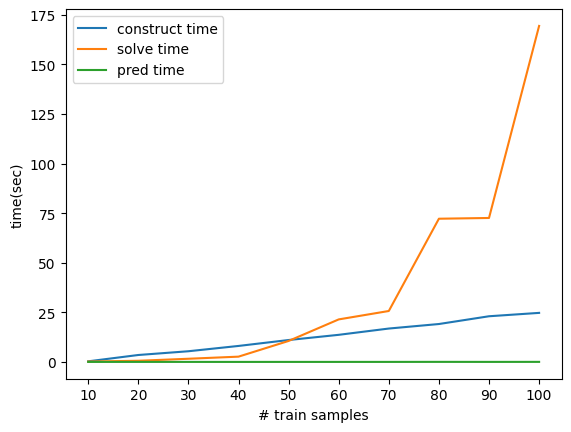

In [51]:
plt.plot(construct_time, label ='construct time')
plt.plot(solve_time, label = 'solve time')
plt.plot(test_time, label = 'pred time')
plt.xticks(np.arange(0, len(construct_time)), np.arange(10, (len(construct_time)+1)*(10), 10))
plt.xlabel("# train samples")
plt.ylabel("time(sec)")
plt.legend()
plt.show()

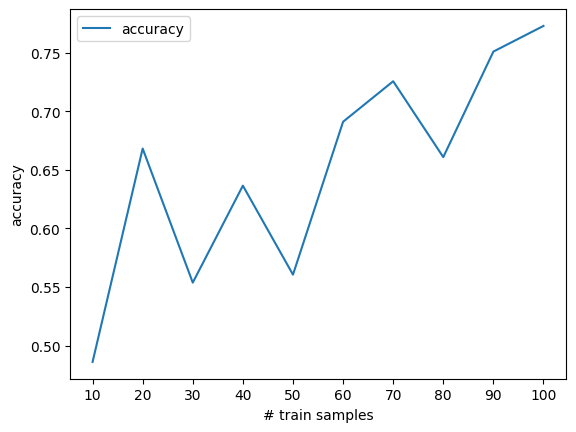

In [52]:
plt.plot(test_acc, label ='accuracy')
plt.xticks(np.arange(0, len(construct_time)), np.arange(10, (len(construct_time)+1)*(10), 10))
plt.xlabel("# train samples")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [46]:
df01, model = train_loop(train_x=train_x_pca, train_y=train_y, test_x=test_x_pca, test_y=test_y,
                         num_features=5, use_quantize=True, cls=[0,1], max_sample=100)

[0 1]
(2, 5)
(2,)
Train size 2 constructed in 0.005212306976318359
status: sat
Train size 2 solved in 0.0025620460510253906
Train size 2 accuracy 0.9888077974319458, pred time 0.0003387928009033203
[0 1]
(22, 5)
(22,)
Train size 22 constructed in 0.03554201126098633
status: sat
Train size 22 solved in 0.015459775924682617
Train size 22 accuracy 0.9654501080513, pred time 0.00026917457580566406
[0 1]
(42, 5)
(42,)
Train size 42 constructed in 0.06485605239868164
status: sat
Train size 42 solved in 0.03861880302429199
Train size 42 accuracy 0.9756690859794617, pred time 0.0002658367156982422
[0 1]
(62, 5)
(62,)
Train size 62 constructed in 0.0970311164855957
status: sat
Train size 62 solved in 0.08990597724914551
Train size 62 accuracy 0.6111922264099121, pred time 0.00023984909057617188
[0 1]
(82, 5)
(82,)
Train size 82 constructed in 0.12532401084899902
status: sat
Train size 82 solved in 0.060160160064697266
Train size 82 accuracy 0.994647204875946, pred time 0.0002460479736328125
[0 

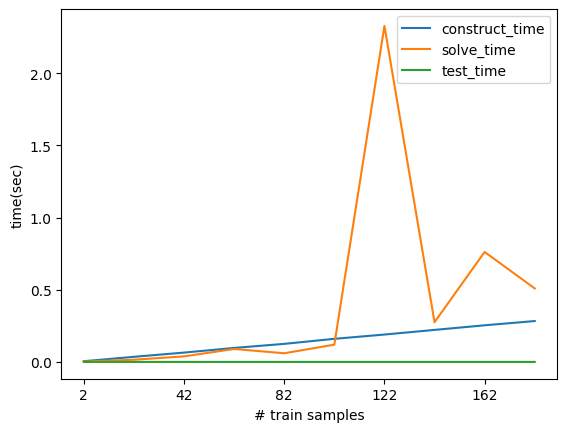

In [49]:
df01[['construct_time','solve_time','test_time']].plot()
plt.xlabel("# train samples")
plt.ylabel("time(sec)")
plt.ylabel("time(sec)")
plt.show()

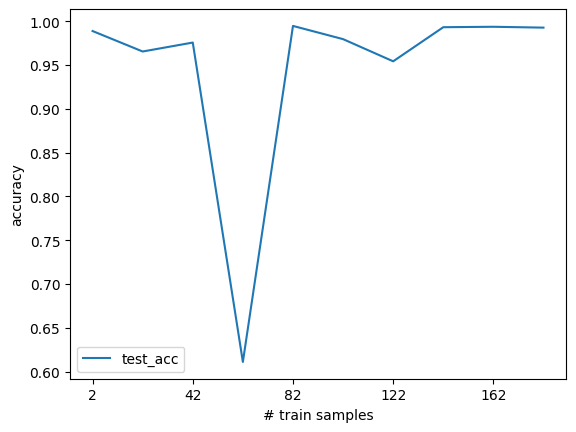

In [50]:
df01[['test_acc']].plot()
plt.xlabel("# train samples")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [17]:
df02, model = train_loop(train_x=train_x_pca, train_y=train_y, test_x=test_x_pca, test_y=test_y,
                         num_features=5, use_quantize=True, cls=[0,1,2], max_sample=100)

[0 1 2]
(3, 5)
(3,)
Train size 3 constructed in 0.00945281982421875
status: sat
Train size 3 solved in 0.01845717430114746
Train size 3 accuracy 0.48210179805755615, pred time 0.0004107952117919922
[0 1 2]
(33, 5)
(33,)
Train size 33 constructed in 0.07851195335388184
status: sat
Train size 33 solved in 0.2738809585571289
Train size 33 accuracy 0.7628899812698364, pred time 0.0006639957427978516
[0 1 2]
(63, 5)
(63,)
Train size 63 constructed in 0.22882723808288574
status: sat
Train size 63 solved in 0.3766140937805176
Train size 63 accuracy 0.9024630784988403, pred time 0.00038886070251464844
[0 1 2]
(93, 5)
(93,)
Train size 93 constructed in 0.21589016914367676
status: unsat
Train size 93 solved in 0.6454870700836182
[0 1 2]
(123, 5)
(123,)
Train size 123 constructed in 0.28730106353759766
status: sat
Train size 123 solved in 0.5482146739959717
Train size 123 accuracy 0.9090312123298645, pred time 0.00041794776916503906
[0 1 2]
(153, 5)
(153,)
Train size 153 constructed in 0.35457921

In [19]:
df02

,construct_time,solve_time,test_time,test_acc,sat_ls
sample_num,,,,,
3,0.009453,0.018457,0.000411,0.482102,sat
33,0.078512,0.273881,0.000664,0.76289,sat
63,0.228827,0.376614,0.000389,0.902463,sat
93,0.21589,0.645487,None,None,unsat
123,0.287301,0.548215,0.000418,0.909031,sat
153,0.354579,6.069404,None,None,unsat
183,0.443246,3.453587,None,None,unsat
213,0.500679,7.86274,None,None,unsat
243,0.56322,2.448952,None,None,unsat


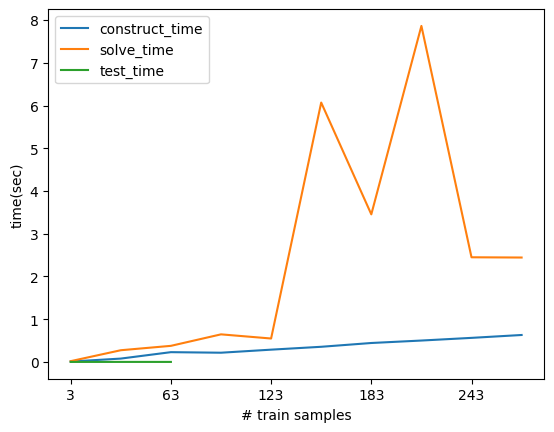

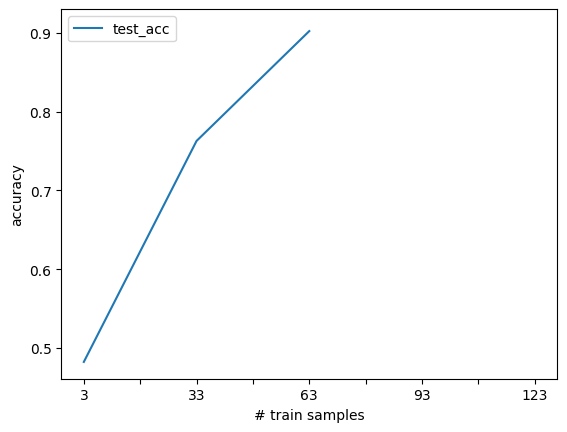

In [18]:
df02[['construct_time','solve_time','test_time']].plot()
plt.xlabel("# train samples")
plt.ylabel("time(sec)")
plt.ylabel("time(sec)")
plt.show()

df02[['test_acc']].plot()
plt.xlabel("# train samples")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [20]:
df02_o, model = train_loop(train_x=train_x_pca, train_y=train_y, test_x=test_x_pca, test_y=test_y,
                         num_features=5, use_quantize=True, cls=[0,1,2], max_sample=40)

[0 1 2]
(3, 5)
(3,)
Train size 3 constructed in 0.013484954833984375
status: sat
Train size 3 solved in 0.002683877944946289
Train size 3 accuracy 0.6916255950927734, pred time 0.00047898292541503906
[0 1 2]
(33, 5)
(33,)
Train size 33 constructed in 0.07857704162597656
status: sat
Train size 33 solved in 0.09714508056640625
Train size 33 accuracy 0.9008210301399231, pred time 0.0003809928894042969
[0 1 2]
(63, 5)
(63,)
Train size 63 constructed in 0.14311695098876953
status: sat
Train size 63 solved in 0.9109790325164795
Train size 63 accuracy 0.9182265996932983, pred time 0.000370025634765625
[0 1 2]
(93, 5)
(93,)
Train size 93 constructed in 0.21427392959594727
status: unsat
Train size 93 solved in 1.5651187896728516


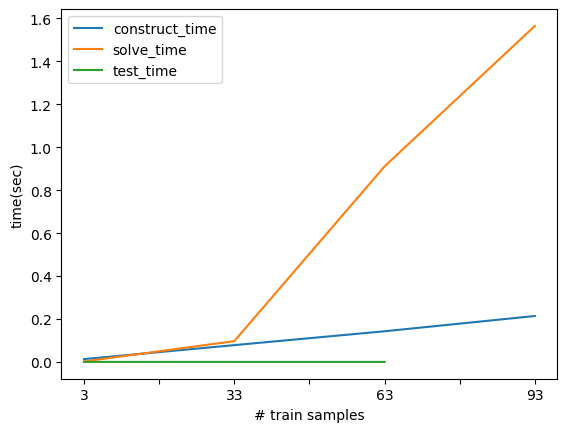

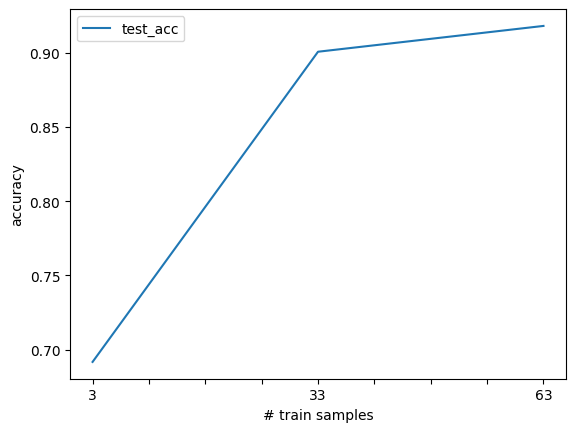

In [21]:
df02_o[['construct_time','solve_time','test_time']].plot()
plt.xlabel("# train samples")
plt.ylabel("time(sec)")
plt.ylabel("time(sec)")
plt.show()

df02_o[['test_acc']].plot()
plt.xlabel("# train samples")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [22]:
df04, model = train_loop(train_x=train_x_pca, train_y=train_y, test_x=test_x_pca, test_y=test_y,
                         use_quantize=True, num_features=5, cls=[0,1,2,3,4], max_sample=40)

[0 1 2 3 4]
(5, 5)
(5,)
Train size 5 constructed in 0.027440786361694336
status: sat
Train size 5 solved in 0.012871980667114258
Train size 5 accuracy 0.22044286131858826, pred time 0.0007309913635253906
[0 1 2 3 4]
(55, 5)
(55,)
Train size 55 constructed in 0.2041621208190918
status: sat
Train size 55 solved in 21.654762029647827
Train size 55 accuracy 0.7267694473266602, pred time 0.0008246898651123047
[0 1 2 3 4]
(105, 5)
(105,)
Train size 105 constructed in 0.4409770965576172
status: sat
Train size 105 solved in 54.892810344696045
Train size 105 accuracy 0.8313562870025635, pred time 0.000946044921875
[0 1 2 3 4]
(155, 5)
(155,)
Train size 155 constructed in 0.5997507572174072
status: unsat
Train size 155 solved in 48.80475211143494


In [24]:
df04

,construct_time,solve_time,test_time,test_acc,sat_ls
sample_num,,,,,
5,0.027441,0.012872,0.000731,0.220443,sat
55,0.204162,21.654762,0.000825,0.726769,sat
105,0.440977,54.89281,0.000946,0.831356,sat
155,0.599751,48.804752,None,None,unsat


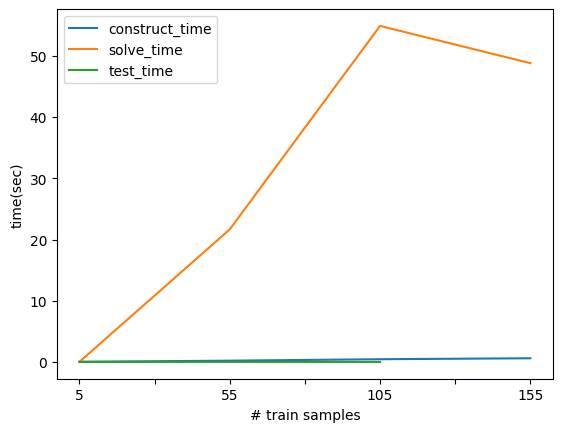

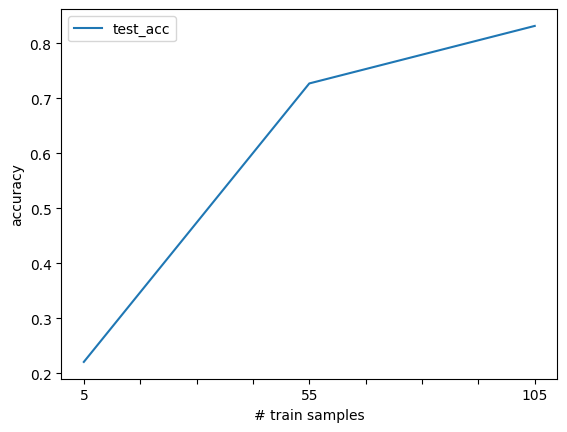

In [23]:
df04[['construct_time','solve_time','test_time']].plot()
plt.xlabel("# train samples")
plt.ylabel("time(sec)")
plt.ylabel("time(sec)")
plt.show()

df04[['test_acc']].plot()
plt.xlabel("# train samples")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [25]:
df04_nq, model = train_loop(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,cls=[0,1,2,3,4], max_sample=40)


[0 1 2 3 4]
(5, 784)
(5,)
Train size 5 constructed in 1.6610300540924072
status: sat
Train size 5 solved in 0.07869100570678711


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_87755/1917213297.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return x @ self.w + self.b


Train size 5 accuracy 0.2396204024553299, pred time 0.03955197334289551
[0 1 2 3 4]
(55, 784)
(55,)
Train size 55 constructed in 18.371459007263184
status: sat
Train size 55 solved in 2.7512800693511963
Train size 55 accuracy 0.206998810172081, pred time 0.022800922393798828
[0 1 2 3 4]
(105, 784)
(105,)
Train size 105 constructed in 36.561354875564575
status: sat
Train size 105 solved in 39.00823998451233
Train size 105 accuracy 0.21431395411491394, pred time 0.025252103805541992
[0 1 2 3 4]
(155, 784)
(155,)
Train size 155 constructed in 57.24714207649231
status: sat
Train size 155 solved in 287.0943160057068
Train size 155 accuracy 0.24219058454036713, pred time 0.04637312889099121


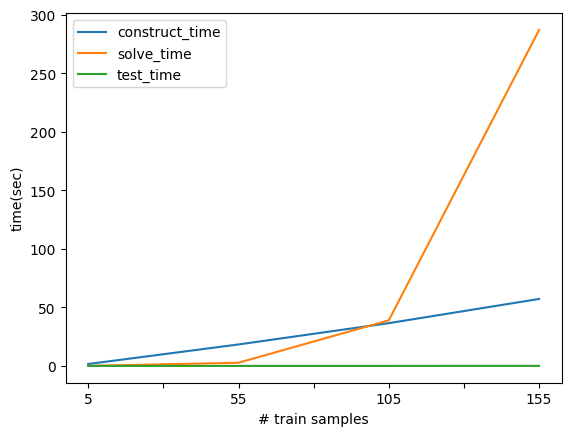

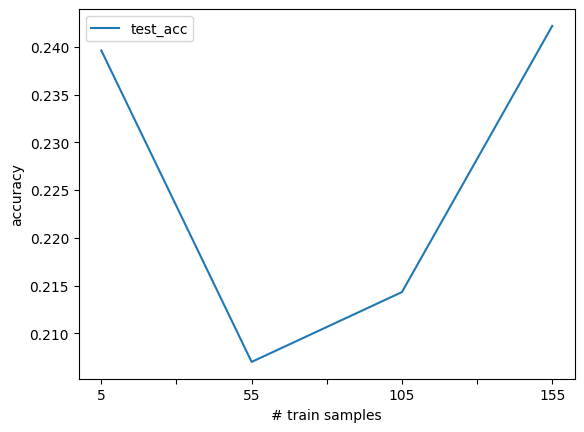

In [26]:
df04_nq[['construct_time','solve_time','test_time']].plot()
plt.xlabel("# train samples")
plt.ylabel("time(sec)")
plt.ylabel("time(sec)")
plt.show()

df04_nq[['test_acc']].plot()
plt.xlabel("# train samples")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
df09, model = train_loop(train_x=train_x_pca, train_y=train_y, test_x=test_x_pca, test_y=test_y,
                         use_quantize=True, num_features=5, cls=[0,1,2,3,4,5,6,7,8,9], max_sample=20)

[0 1 2 3 4 5 6 7 8 9]
(10, 5)
(10,)
Train size 10 constructed in 0.09990310668945312
status: sat
Train size 10 solved in 0.18991518020629883
Train size 10 accuracy 0.2711000144481659, pred time 0.003587961196899414
[0 1 2 3 4 5 6 7 8 9]
(110, 5)
(110,)
Train size 110 constructed in 1.0036139488220215


(10000, 2)
(50000, 2)


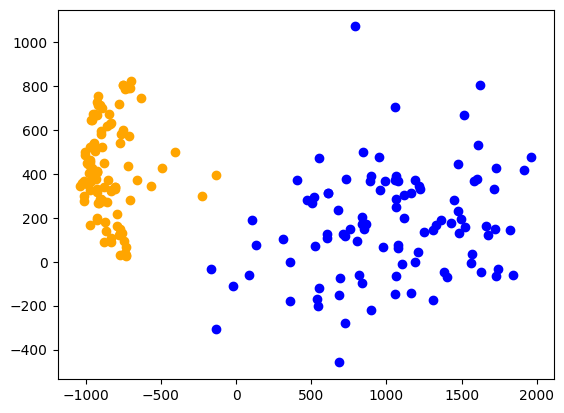

In [17]:
pca = PCA(n_components=2)
train_x_pca2 = pca.fit_transform(trainset.data.flatten(start_dim=1))

test_x_pca2 = train_x_pca2[50000:,:]
train_x_pca2 = train_x_pca2[:50000,:]

print(test_x_pca2.shape)
print(train_x_pca2.shape)

x_sample, y_sample = construct_train_set(train_x_pca2, train_y, num_per_class=100, cls = [0,1])

idx_ls=[]
for idx, i in enumerate(y_sample):
    if i == 0:
        idx_ls.append(idx)

plt.scatter(x_sample[y_sample==1][:,0], x_sample[y_sample==1][:,1], color='orange')
plt.scatter(x_sample[y_sample==0][:,0], x_sample[y_sample==0][:,1], color='blue')

(10000, 2)
(50000, 2)


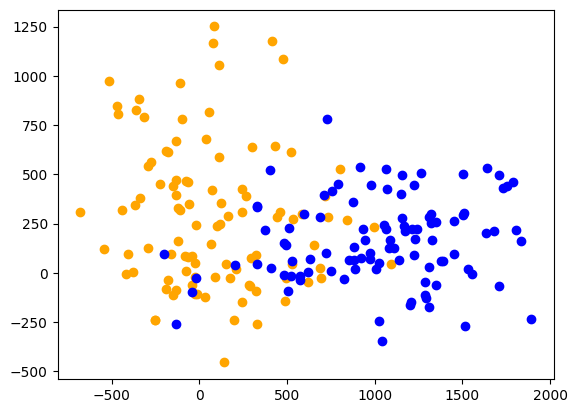

In [19]:
pca = PCA(n_components=2)
train_x_pca2 = pca.fit_transform(trainset.data.flatten(start_dim=1))

test_x_pca2 = train_x_pca2[50000:,:]
train_x_pca2 = train_x_pca2[:50000,:]

print(test_x_pca2.shape)
print(train_x_pca2.shape)

x_sample, y_sample = construct_train_set(train_x_pca2, train_y, num_per_class=100, cls = [0,2])

idx_ls=[]
for idx, i in enumerate(y_sample):
    if i == 0:
        idx_ls.append(idx)

plt.scatter(x_sample[y_sample==2][:,0], x_sample[y_sample==2][:,1], color='orange')
plt.scatter(x_sample[y_sample==0][:,0], x_sample[y_sample==0][:,1], color='blue')        